In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 11.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import random

In [3]:

# Reproducibilidad
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


In [4]:
# Cargar dataset
df = pd.read_csv("/content/btcusd_1-min_data.csv")
df['Date'] = pd.to_datetime(df['Timestamp'], unit='s')
df = df.set_index('Date')[['Close']].copy()
df.dropna(inplace=True)

In [5]:
# Escalado
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(df[['Close']].values).flatten()

In [6]:
# Función para crear secuencias
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

In [8]:
# Modelo LSTM
class BitcoinLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(BitcoinLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

def objective(trial):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    try:
        # Hiperparámetros
        params = {
            # 'seq_len': trial.suggest_int('seq_len', 10, 50),
            # 'hidden_size': trial.suggest_categorical('hidden_size', [16, 32, 64, 128]),
            # 'num_layers': trial.suggest_int('num_layers', 1, 3),
            # 'dropout': trial.suggest_float('dropout', 0.0, 0.5),
            # 'lr': trial.suggest_float('lr', 1e-4, 1e-2, log=True),
            # 'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128])
            'seq_len': 30,
            'hidden_size': 128,
            'num_layers': 1,
            'dropout': 0.12592806791831518,
            'lr': 0.00011195860024489018,
            'batch_size': 128
            }

        X, y_seq = create_sequences(scaled_close, params['seq_len'])
        if len(X) < 500:
            return float('inf')

        split_idx = int(len(X) * 0.8)
        X_train, X_val = X[:split_idx], X[split_idx:]
        y_train, y_val = y_seq[:split_idx], y_seq[split_idx:]

        train_loader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(
                torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1),
                torch.tensor(y_train, dtype=torch.float32).view(-1, 1)),
            batch_size=params['batch_size'], shuffle=True)

        val_loader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(
                torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1),
                torch.tensor(y_val, dtype=torch.float32).view(-1, 1)),
            batch_size=params['batch_size'], shuffle=False)

        model = BitcoinLSTM(1, params['hidden_size'], params['num_layers'], params['dropout']).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
        criterion = nn.MSELoss()

        best_val_loss = float('inf')
        for epoch in range(20):
            model.train()
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                loss = criterion(model(X_batch), y_batch)
                loss.backward()
                optimizer.step()

            model.eval()
            val_loss_total, count = 0.0, 0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    val_preds = model(X_batch)
                    loss = criterion(val_preds, y_batch).item()
                    val_loss_total += loss * X_batch.size(0)
                    count += X_batch.size(0)
            val_loss = val_loss_total / count

            trial.report(val_loss, epoch)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

            best_val_loss = min(best_val_loss, val_loss)

        return best_val_loss

    except Exception as e:
        return float('inf')

In [ ]:
# # Optimización
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=10, show_progress_bar=True)

# print("Mejores hiperparámetros:")
# print(study.best_params)

[I 2025-05-26 21:56:42,131] A new study created in memory with name: no-name-0067d222-0729-43f7-926b-369b61d64ea8


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.15046729592408603 and num_layers=1
  warnings.warn(


In [9]:
# Entrenamiento final con mejores hiperparámetros
# best_params = study.best_params
# X, y_seq = create_sequences(scaled_close, best_params['seq_len'])
X, y_seq = create_sequences(scaled_close, 30)
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)
X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y_seq[:train_size], y_seq[train_size:train_size+val_size], y_seq[train_size+val_size:]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1),
        torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    # ), batch_size=best_params['batch_size'], shuffle=True)
    ), batch_size=128, shuffle=True)


model = BitcoinLSTM(
    input_size=1,
    # hidden_size=best_params['hidden_size'],
    # num_layers=best_params['num_layers'],
    # dropout=best_params['dropout']
    hidden_size=128,
    num_layers=1,
    dropout=0.12592806791831518
).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.00011195860024489018)
criterion = nn.MSELoss()

for epoch in range(15):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        loss = criterion(model(X_batch), y_batch)
        loss.backward()
        optimizer.step()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.12592806791831518 and num_layers=1
  warnings.warn(


In [16]:
# Evaluación final por lotes
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1),
        torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
    ),
    batch_size=128,
    shuffle=False
)

model.eval()
all_preds = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        preds = model(X_batch).cpu().numpy()
        all_preds.append(preds)

# Concatenar todos los resultados
preds = np.concatenate(all_preds)

# Desescalar
actual = scaler.inverse_transform(y_test.reshape(-1, 1))
predicted = scaler.inverse_transform(preds)

In [17]:
# Métrica final
rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f"RMSE en test: {rmse:.4f}")

RMSE en test: 0.0195


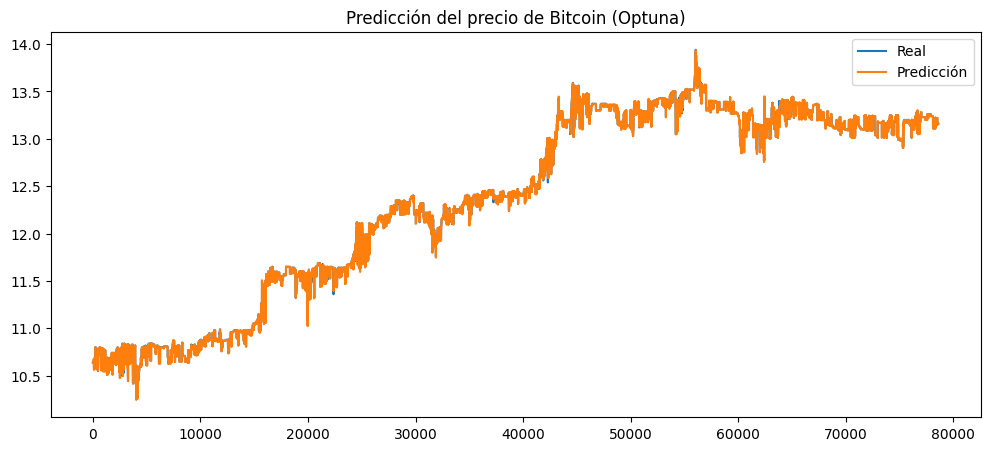

In [18]:
# Gráfica
plt.figure(figsize=(12, 5))
plt.plot(actual, label='Real')
plt.plot(predicted, label='Predicción')
plt.legend()
plt.title("Predicción del precio de Bitcoin (Optuna)")
plt.show()


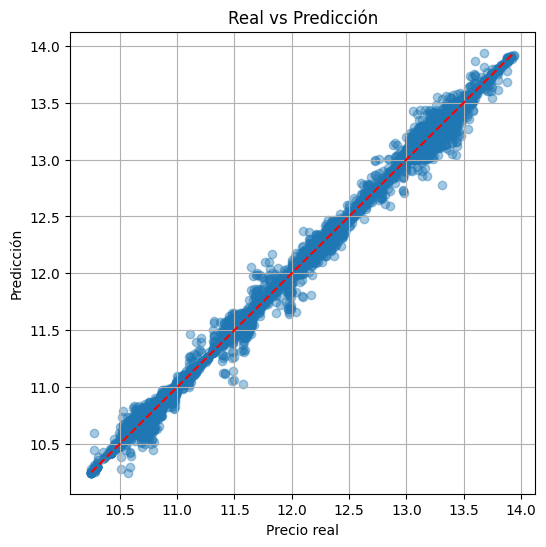

In [19]:
plt.figure(figsize=(6, 6))
plt.scatter(actual, predicted, alpha=0.4)
plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--')  # Línea identidad
plt.xlabel("Precio real")
plt.ylabel("Predicción")
plt.title("Real vs Predicción")
plt.grid(True)
plt.show()

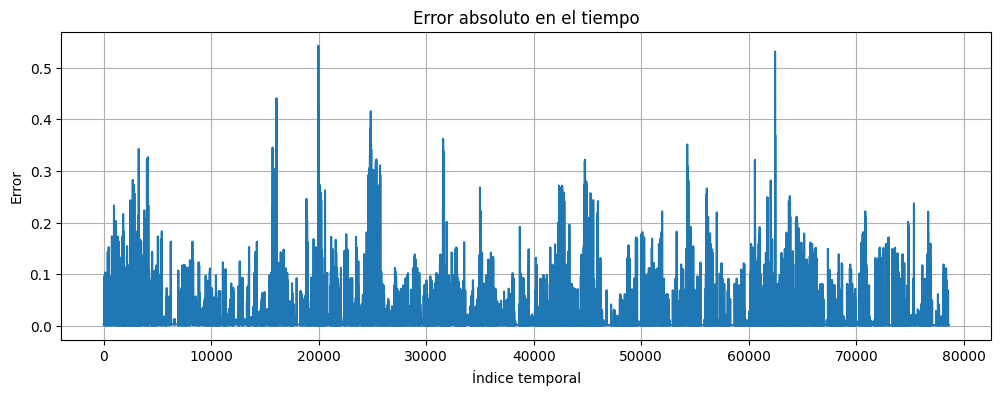

In [20]:
error = np.abs(actual - predicted)
plt.figure(figsize=(12, 4))
plt.plot(error)
plt.title("Error absoluto en el tiempo")
plt.xlabel("Índice temporal")
plt.ylabel("Error")
plt.grid(True)
plt.show()

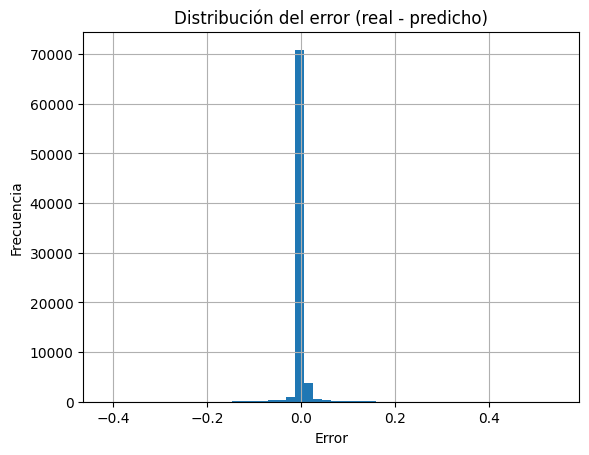

In [21]:
plt.hist(actual - predicted, bins=50)
plt.title("Distribución del error (real - predicho)")
plt.xlabel("Error")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))
r2 = r2_score(actual, predicted)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

MAE: 0.0057
RMSE: 0.0195
R² Score: 0.9996
